In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image,  scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from PIL import Image, ImageDraw, ImageFont

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores >= threshold
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes.eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = [41 34  7 ... 52 56 78]
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [5]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')   
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 
    nms_indices = tf.image.non_max_suppression( boxes, scores, max_boxes_tensor, iou_threshold)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    return scores, boxes, classes

In [7]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [8]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


In [9]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.5, iou_threshold=.6):
  
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    return scores, boxes, classes

In [10]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [11]:
sess = K.get_session()

In [12]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [13]:
yolo_model = load_model("model_data/yolo.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [15]:
yolo_model.save('yolo_model.h5')

In [16]:
print(yolo_model.output)
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

Tensor("conv2d_23/BiasAdd:0", shape=(?, 19, 19, 425), dtype=float32)
Tensor("strided_slice_12:0", shape=(2,), dtype=int32)


In [17]:
input_image_shape = K.placeholder(shape=(2, ))
scores, boxes, classes = yolo_eval(yolo_outputs, input_image_shape)

In [18]:
def draw_boxess(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))
        if(predicted_class == 'car' or predicted_class == 'bus' or predicted_class == 'truck'):
            mid_x = (box[1]+box[3])/2
            mid_y = (box[0]+box[2])/2
            apx_distance = round(((box[3] - box[1])/100),1)
            draw.text((int(mid_x),int(mid_y)),'{}'.format(apx_distance),font=font,fill=(255,255,255))
            if(apx_distance>=3.0):
                if(mid_x>300 and mid_x<800):
                    draw.text(np.array([int(mid_x),int(mid_y+20)]),'Warning!!!!!!',fill=(0,0,255),font=font,fontsize=70)
        
        if(predicted_class == 'person'):
            mid_x = (box[1]+box[3])/2
            mid_y = (box[0]+box[2])/2
            apx_distance = round(((box[3] - box[1])/100),1)
            draw.text((int(mid_x),int(mid_y)),'{}'.format(apx_distance),font=font,fill=(255,255,255))
            if(apx_distance>=1.2):
                if(mid_x>300 and mid_x<800):
                    draw.text(np.array([int(mid_x),int(mid_y)]),'Warning!!!!!!',fill=(255,0,0),font=font,fontsize=52)
        
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
       
        

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [19]:
def predict(sess, image_file):
  
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data,
                                                                                       input_image_shape: [image.size[1], image.size[0]],
                                                                                       K.learning_phase(): 0})
    
    

    print (type(image))
    print (type(image_data))
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxess(image, out_scores, out_boxes, out_classes, class_names, colors)

    image.save(os.path.join("out", image_file), quality=900)
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    
    
    
        
    imshow(output_image)
    return out_scores, out_boxes, out_classes

In [20]:
def preprocess_images(imagee, model_image_size):
    #image = PIL.Image.fromarray(imagee)
    #image_type = imghdr.what(image)
    #image = Image.open(image)
    resized_image = imagee.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return imagee, image_data

In [21]:
def predicts(sess, image_files):
    image_file = PIL.Image.fromarray(image_files)
  
    image, image_data = preprocess_images(image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data,
                                                                                       input_image_shape: [image.size[1], image.size[0]],
                                                                                       K.learning_phase(): 0})
   
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxess(image, out_scores, out_boxes, out_classes, class_names, colors)

    #image.save(os.path.join("out", image_file), quality=900)
    #output_image = scipy.misc.imread(os.path.join("out", image_file))
    
    
    
        
    imshow(image)
    return image

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame165.jpg
car 0.66 (804, 331) (1052, 420)
car 0.86 (491, 348) (776, 522)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


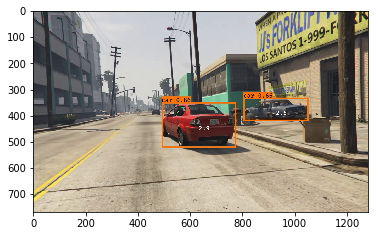

In [22]:
out_scores, out_boxes, out_classes = predict(sess, "frame165.jpg")

In [23]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal
import imghdr

In [24]:
cam = cv2.VideoCapture("C:\\Users\\AK\\YOLO_Object_Localization_Keras-master\\Video\\Project 2.mp4")

In [ ]:
try: 
      
    # creating a folder named data 
    if not os.path.exists('images'): 
        os.makedirs('images') 
  
#if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 
  
# frame 
currentframe = 0
  
while(True): 
    
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './images/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
        

        # increasing counter so that it will 
        # show how many frames are created 
       
        out_scores, out_boxes, out_classes = predict(sess,'frame'+str(currentframe)+'.jpg')
        currentframe += 1
    else: 
        break

Creating..../images/frame0.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame0.jpg


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


<IPython.core.display.Javascript object>

Creating..../images/frame1.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1.jpg
car 0.61 (618, 347) (782, 418)
Creating..../images/frame2.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame2.jpg
Creating..../images/frame3.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame3.jpg
Creating..../images/frame4.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame4.jpg
Creating..../images/frame5.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame5.jpg
car 0.62 (619, 345) (782, 417)
Creating..../images/frame6.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame6.jpg
car 0.61 (617, 345) (782, 417)
Creating..../images/frame7.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame7.jpg
car 0.62 (6

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame55.jpg
car 0.62 (619, 346) (780, 417)
Creating..../images/frame56.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame56.jpg
Creating..../images/frame57.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame57.jpg
Creating..../images/frame58.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame58.jpg
Creating..../images/frame59.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame59.jpg
Creating..../images/frame60.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame60.jpg
Creating..../images/frame61.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame61.jpg
Creating..../images/frame62.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.n

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame109.jpg
car 0.80 (620, 360) (803, 443)
car 0.91 (670, 298) (1280, 768)
Creating..../images/frame110.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame110.jpg
car 0.70 (627, 361) (798, 438)
car 0.86 (642, 306) (1280, 768)
Creating..../images/frame111.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame111.jpg
car 0.68 (628, 360) (805, 435)
car 0.83 (633, 304) (1280, 768)
Creating..../images/frame112.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame112.jpg
car 0.65 (635, 359) (821, 432)
car 0.83 (630, 306) (1280, 768)
Creating..../images/frame113.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame113.jpg
car 0.67 (630, 355) (815, 433)
car 0.84 (625, 294) (1280, 768)
Creating..../images/frame114.jpg
<class 'PIL.JpegImagePlug

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame156.jpg
car 0.77 (801, 334) (1045, 416)
car 0.86 (513, 361) (872, 548)
Creating..../images/frame157.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame157.jpg
car 0.76 (801, 338) (1045, 418)
car 0.88 (508, 365) (867, 544)
Creating..../images/frame158.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame158.jpg
car 0.75 (798, 337) (1047, 422)
car 0.89 (505, 367) (859, 544)
Creating..../images/frame159.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame159.jpg
car 0.71 (803, 339) (1039, 424)
car 0.80 (496, 358) (838, 543)
Creating..../images/frame160.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame160.jpg
car 0.84 (494, 361) (837, 540)
Creating..../images/frame161.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame200.jpg
truck 0.70 (804, 312) (1130, 407)
car 0.78 (492, 348) (606, 435)
Creating..../images/frame201.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame201.jpg
truck 0.70 (809, 309) (1128, 406)
car 0.80 (492, 342) (605, 436)
Creating..../images/frame202.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame202.jpg
truck 0.60 (806, 306) (1128, 407)
car 0.83 (488, 342) (603, 433)
Creating..../images/frame203.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame203.jpg
truck 0.67 (804, 303) (1131, 408)
car 0.83 (488, 340) (602, 432)
Creating..../images/frame204.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame204.jpg
truck 0.76 (803, 305) (1124, 406)
car 0.83 (489, 343) (598, 432)
Creating..../images/frame205.jpg
<class 'PIL.Jpe

Creating..../images/frame244.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame244.jpg
truck 0.63 (808, 338) (1118, 439)
car 0.78 (465, 380) (544, 436)
Creating..../images/frame245.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame245.jpg
truck 0.72 (804, 337) (1122, 437)
car 0.75 (464, 380) (545, 434)
Creating..../images/frame246.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame246.jpg
truck 0.65 (809, 336) (1126, 437)
car 0.78 (461, 378) (544, 434)
Creating..../images/frame247.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame247.jpg
car 0.78 (461, 379) (544, 434)
Creating..../images/frame248.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame248.jpg
car 0.69 (460, 379) (541, 433)
Creating..../images/frame249.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame297.jpg
truck 0.72 (806, 338) (1119, 437)
Creating..../images/frame298.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame298.jpg
car 0.66 (463, 385) (518, 428)
Creating..../images/frame299.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame299.jpg
car 0.65 (461, 387) (515, 426)
Creating..../images/frame300.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame300.jpg
truck 0.66 (816, 342) (1127, 443)
car 0.70 (460, 390) (514, 427)
Creating..../images/frame301.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame301.jpg
car 0.64 (463, 391) (512, 427)
Creating..../images/frame302.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame302.jpg
car 0.63 (466, 392) (511, 427)
truck 0.71 (803, 3

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame346.jpg
Creating..../images/frame347.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame347.jpg
Creating..../images/frame348.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame348.jpg
Creating..../images/frame349.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame349.jpg
Creating..../images/frame350.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame350.jpg
Creating..../images/frame351.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame351.jpg
Creating..../images/frame352.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame352.jpg
car 0.68 (1029, 355) (1270, 461)
Creating..../images/frame353.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame405.jpg
Creating..../images/frame406.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame406.jpg
Creating..../images/frame407.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame407.jpg
car 0.63 (596, 388) (645, 426)
Creating..../images/frame408.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame408.jpg
Creating..../images/frame409.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame409.jpg
Creating..../images/frame410.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame410.jpg
Creating..../images/frame411.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame411.jpg
fire hydrant 0.66 (834, 376) (870, 439)
Creating..../images/frame412.jpg
<clas

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame459.jpg
car 0.70 (576, 403) (643, 456)
fire hydrant 0.74 (1218, 432) (1278, 578)
Creating..../images/frame460.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame460.jpg
car 0.77 (575, 402) (645, 456)
Creating..../images/frame461.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame461.jpg
car 0.75 (575, 403) (644, 456)
Creating..../images/frame462.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame462.jpg
car 0.70 (575, 402) (644, 455)
Creating..../images/frame463.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame463.jpg
car 0.78 (575, 403) (643, 459)
Creating..../images/frame464.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame464.jpg
car 0.78 (573, 404) (646, 458)
Creating..../

Creating..../images/frame510.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame510.jpg
car 0.65 (541, 324) (680, 441)
Creating..../images/frame511.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame511.jpg
car 0.66 (540, 324) (683, 444)
Creating..../images/frame512.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame512.jpg
car 0.63 (539, 323) (682, 443)
Creating..../images/frame513.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame513.jpg
car 0.61 (538, 319) (684, 443)
Creating..../images/frame514.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame514.jpg
car 0.77 (539, 324) (685, 444)
Creating..../images/frame515.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame515.jpg
car 0.80 (539, 323) (688, 444)
Creating..../images/fr

Creating..../images/frame555.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame555.jpg
traffic light 0.65 (399, 171) (429, 223)
car 0.85 (491, 376) (715, 575)
Creating..../images/frame556.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame556.jpg
car 0.86 (492, 379) (712, 576)
Creating..../images/frame557.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame557.jpg
car 0.88 (491, 380) (713, 578)
Creating..../images/frame558.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame558.jpg
car 0.84 (489, 380) (714, 581)
Creating..../images/frame559.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame559.jpg
car 0.86 (488, 377) (715, 583)
Creating..../images/frame560.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame560.jpg
car 0.81 (47

Creating..../images/frame597.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame597.jpg
car 0.65 (431, 364) (553, 399)
car 0.89 (832, 313) (1270, 768)
Creating..../images/frame598.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame598.jpg
car 0.87 (840, 307) (1275, 768)
Creating..../images/frame599.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame599.jpg
car 0.86 (848, 302) (1273, 768)
Creating..../images/frame600.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame600.jpg
car 0.77 (863, 296) (1277, 768)
Creating..../images/frame601.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame601.jpg
car 0.76 (893, 295) (1270, 768)
Creating..../images/frame602.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame602.jpg
car 0.81 (901, 29

Creating..../images/frame645.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame645.jpg
car 0.82 (1075, 338) (1280, 756)
Creating..../images/frame646.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame646.jpg
car 0.83 (1082, 340) (1280, 751)
Creating..../images/frame647.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame647.jpg
car 0.85 (1086, 339) (1280, 758)
Creating..../images/frame648.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame648.jpg
car 0.61 (1070, 356) (1276, 510)
car 0.85 (1095, 343) (1280, 757)
Creating..../images/frame649.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame649.jpg
car 0.64 (1074, 365) (1273, 512)
car 0.64 (992, 396) (1058, 421)
car 0.82 (1104, 346) (1280, 755)
Creating..../images/frame650.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>


<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame687.jpg
car 0.64 (354, 410) (489, 451)
car 0.88 (977, 372) (1276, 562)
Creating..../images/frame688.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame688.jpg
car 0.62 (326, 413) (457, 457)
car 0.88 (950, 374) (1280, 561)
Creating..../images/frame689.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame689.jpg
car 0.68 (302, 415) (439, 457)
car 0.89 (932, 374) (1280, 565)
Creating..../images/frame690.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame690.jpg
car 0.64 (285, 413) (429, 458)
car 0.89 (915, 374) (1274, 571)
Creating..../images/frame691.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame691.jpg
car 0.62 (254, 413) (399, 462)
car 0.87 (901, 377) (1238, 564)
Creating..../images/frame692.jpg
<class 'PIL.JpegImagePlug

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame724.jpg
car 0.65 (867, 391) (953, 427)
car 0.70 (987, 392) (1277, 702)
car 0.77 (9, 430) (213, 488)
bus 0.78 (1062, 345) (1258, 421)
Creating..../images/frame725.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame725.jpg
traffic light 0.63 (1071, 143) (1097, 206)
car 0.72 (15, 422) (217, 483)
car 0.73 (1003, 382) (1278, 709)
bus 0.80 (1074, 345) (1258, 417)
Creating..../images/frame726.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame726.jpg
traffic light 0.61 (1080, 138) (1108, 200)
car 0.68 (16, 419) (215, 477)
car 0.69 (1038, 398) (1267, 699)
bus 0.78 (1084, 343) (1266, 411)
Creating..../images/frame727.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame727.jpg
car 0.66 (18, 408) (208, 466)
car 0.75 (1050, 401) (1275, 692)
bus 0.79 (1085, 340) (1266, 406)
Creati

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame762.jpg
traffic light 0.65 (872, 98) (897, 162)
car 0.76 (19, 423) (242, 538)
bus 0.81 (889, 312) (1068, 396)
Creating..../images/frame763.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame763.jpg
traffic light 0.65 (875, 96) (899, 163)
car 0.67 (5, 416) (243, 565)
bus 0.79 (893, 314) (1070, 397)
Creating..../images/frame764.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame764.jpg
traffic light 0.67 (875, 93) (902, 167)
car 0.69 (1, 420) (238, 571)
bus 0.79 (897, 319) (1073, 399)
Creating..../images/frame765.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame765.jpg
traffic light 0.63 (1059, 4) (1103, 111)
traffic light 0.65 (879, 95) (907, 167)
car 0.75 (0, 424) (226, 571)
bus 0.79 (891, 329) (1082, 404)
Creating..../images/frame766.jpg
<class 'PIL.JpegImagePlugi

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame803.jpg
bus 0.60 (1228, 320) (1280, 455)
car 0.65 (916, 390) (1076, 447)
Creating..../images/frame804.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame804.jpg
car 0.62 (385, 403) (457, 452)
car 0.72 (917, 383) (1086, 444)
Creating..../images/frame805.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame805.jpg
car 0.65 (382, 401) (452, 450)
car 0.74 (923, 377) (1087, 442)
Creating..../images/frame806.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame806.jpg
car 0.67 (375, 398) (449, 451)
car 0.70 (922, 376) (1088, 441)
Creating..../images/frame807.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame807.jpg
car 0.67 (925, 377) (1081, 438)
car 0.70 (369, 397) (448, 451)
Creating..../images/frame808.jpg
<class 'PIL.JpegImagePl

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame842.jpg
car 0.65 (3, 384) (343, 540)
car 0.67 (473, 401) (539, 444)
traffic light 0.68 (600, 171) (627, 239)
Creating..../images/frame843.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame843.jpg
car 0.65 (474, 404) (541, 446)
car 0.68 (0, 383) (338, 553)
traffic light 0.70 (601, 169) (628, 241)
Creating..../images/frame844.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame844.jpg
car 0.67 (6, 383) (329, 559)
traffic light 0.67 (604, 169) (630, 240)
Creating..../images/frame845.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame845.jpg
traffic light 0.69 (604, 167) (630, 230)
car 0.71 (475, 404) (551, 450)
car 0.81 (4, 382) (322, 565)
Creating..../images/frame846.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame846.jpg


<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame885.jpg
bench 0.63 (1039, 414) (1168, 466)
car 0.79 (0, 376) (353, 722)
Creating..../images/frame886.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame886.jpg
bench 0.62 (1082, 402) (1268, 474)
person 0.64 (61, 407) (159, 498)
car 0.82 (3, 378) (312, 768)
Creating..../images/frame887.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame887.jpg
bench 0.60 (1070, 407) (1259, 473)
person 0.63 (1214, 389) (1273, 481)
person 0.63 (0, 412) (103, 501)
car 0.78 (0, 376) (293, 710)
Creating..../images/frame888.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame888.jpg
bench 0.64 (1065, 411) (1257, 470)
car 0.87 (0, 367) (256, 724)
Creating..../images/frame889.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame889.jpg
bench 0.65 (1086

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame937.jpg
car 0.79 (726, 336) (832, 400)
Creating..../images/frame938.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame938.jpg
car 0.72 (500, 339) (572, 393)
car 0.80 (729, 334) (845, 405)
Creating..../images/frame939.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame939.jpg
car 0.72 (500, 342) (574, 395)
car 0.84 (731, 337) (857, 411)
Creating..../images/frame940.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame940.jpg
car 0.62 (501, 342) (579, 396)
car 0.79 (734, 337) (860, 411)
Creating..../images/frame941.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame941.jpg
car 0.76 (503, 347) (579, 399)
car 0.79 (740, 340) (866, 414)
Creating..../images/frame942.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.nda

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame983.jpg
car 0.79 (1122, 385) (1280, 618)
Creating..../images/frame984.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame984.jpg
car 0.60 (1155, 392) (1279, 610)
Creating..../images/frame985.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame985.jpg
Creating..../images/frame986.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame986.jpg
Creating..../images/frame987.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame987.jpg
Creating..../images/frame988.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame988.jpg
Creating..../images/frame989.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame989.jpg
Creating..../images/frame990.jpg
<class 'PI

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1032.jpg
car 0.84 (0, 369) (433, 715)
Creating..../images/frame1033.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1033.jpg
car 0.75 (0, 367) (397, 730)
Creating..../images/frame1034.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1034.jpg
car 0.75 (0, 363) (395, 742)
Creating..../images/frame1035.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1035.jpg
car 0.64 (0, 361) (371, 750)
Creating..../images/frame1036.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1036.jpg
truck 0.74 (0, 356) (355, 751)
Creating..../images/frame1037.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1037.jpg
Creating..../images/frame1038.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<clas

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1079.jpg
person 0.66 (713, 402) (756, 515)
car 0.76 (393, 373) (522, 498)
Creating..../images/frame1080.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1080.jpg
person 0.71 (712, 399) (759, 518)
car 0.80 (381, 400) (512, 494)
Creating..../images/frame1081.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1081.jpg
person 0.65 (707, 395) (751, 520)
car 0.72 (372, 380) (503, 496)
Creating..../images/frame1082.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1082.jpg
person 0.70 (706, 393) (750, 520)
car 0.84 (356, 395) (495, 503)
Creating..../images/frame1083.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1083.jpg
person 0.69 (705, 392) (749, 519)
car 0.85 (339, 398) (483, 502)
Creating..../images/frame1084.jpg
<clas

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame1119.jpg
person 0.70 (1064, 137) (1280, 768)
truck 0.72 (245, 80) (417, 354)
person 0.72 (663, 245) (713, 379)
car 0.74 (6, 198) (150, 476)
Creating..../images/frame1120.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame1120.jpg
person 0.67 (1075, 190) (1280, 746)
car 0.68 (0, 193) (120, 421)
truck 0.72 (235, 75) (416, 274)
person 0.74 (653, 256) (707, 372)
Creating..../images/frame1121.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1121.jpg
truck 0.76 (213, 73) (404, 287)
person 0.79 (651, 258) (692, 373)
Creating..../images/frame1122.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1122.jpg
person 0.62 (1185, 299) (1279, 768)
truck 0.75 (163, 80) (406, 350)
person 0.82 (644, 259) (691, 371)
Creating..../images/frame1123.jpg
<class 'PIL.JpegImagePlugin.JpegIm

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1157.jpg
person 0.83 (475, 249) (560, 522)
Creating..../images/frame1158.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1158.jpg
person 0.62 (220, 279) (269, 385)
person 0.82 (473, 249) (564, 523)
Creating..../images/frame1159.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1159.jpg
person 0.63 (216, 279) (262, 383)
person 0.82 (472, 249) (567, 525)
Creating..../images/frame1160.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1160.jpg
car 0.60 (83, 291) (165, 347)
person 0.63 (213, 283) (260, 384)
person 0.82 (474, 248) (572, 524)
Creating..../images/frame1161.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1161.jpg
car 0.66 (86, 293) (164, 347)
person 0.82 (475, 245) (575, 531)
Creating..../images/frame1162.jp

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1196.jpg
person 0.71 (195, 326) (231, 422)
person 0.78 (426, 229) (570, 604)
Creating..../images/frame1197.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1197.jpg
person 0.73 (192, 325) (230, 426)
person 0.81 (422, 235) (568, 609)
Creating..../images/frame1198.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1198.jpg
car 0.61 (83, 330) (171, 379)
person 0.77 (190, 326) (229, 429)
person 0.81 (426, 242) (566, 609)
Creating..../images/frame1199.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1199.jpg
person 0.76 (190, 323) (229, 433)
person 0.79 (423, 247) (568, 609)
Creating..../images/frame1200.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1200.jpg
car 0.67 (88, 330) (168, 386)
person 0.74 (190, 325) (229, 437

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1238.jpg
person 0.76 (169, 363) (224, 471)
person 0.82 (435, 311) (541, 605)
Creating..../images/frame1239.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1239.jpg
person 0.80 (172, 362) (225, 472)
person 0.83 (435, 307) (543, 605)
Creating..../images/frame1240.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1240.jpg
person 0.66 (171, 364) (222, 470)
person 0.83 (435, 302) (541, 606)
Creating..../images/frame1241.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1241.jpg
person 0.63 (182, 359) (228, 470)
person 0.85 (434, 300) (544, 607)
Creating..../images/frame1242.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1242.jpg
person 0.72 (181, 358) (237, 469)
person 0.84 (435, 291) (551, 608)
Creating..../images/fram

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame1275.jpg
car 0.66 (0, 429) (76, 595)
person 0.76 (463, 364) (499, 480)
truck 0.85 (0, 40) (425, 541)
person 0.87 (744, 326) (906, 678)
Creating..../images/frame1276.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1276.jpg
person 0.74 (472, 370) (510, 481)
person 0.85 (757, 323) (932, 682)
truck 0.86 (0, 56) (450, 531)
Creating..../images/frame1277.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1277.jpg
person 0.79 (496, 370) (534, 484)
person 0.83 (780, 323) (945, 699)
truck 0.85 (0, 53) (464, 538)
Creating..../images/frame1278.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 4 boxes for frame1278.jpg
car 0.62 (0, 380) (99, 637)
person 0.78 (506, 374) (546, 485)
person 0.83 (794, 322) (947, 700)
truck 0.85 (0, 55) (458, 537)
Creating..../images/frame1279.jpg
<class 'PIL.Jpeg

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1310.jpg
person 0.80 (1102, 303) (1276, 765)
person 0.80 (588, 372) (642, 522)
truck 0.85 (21, 56) (559, 543)
Creating..../images/frame1311.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1311.jpg
person 0.79 (589, 374) (643, 523)
person 0.79 (1111, 273) (1275, 762)
truck 0.84 (20, 61) (568, 541)
Creating..../images/frame1312.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1312.jpg
person 0.77 (1127, 266) (1280, 750)
person 0.78 (587, 374) (644, 524)
truck 0.85 (32, 42) (587, 498)
Creating..../images/frame1313.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 3 boxes for frame1313.jpg
person 0.61 (1177, 280) (1279, 489)
person 0.77 (585, 371) (644, 529)
truck 0.87 (50, 68) (547, 537)
Creating..../images/frame1314.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.nd

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1352.jpg
car 0.67 (133, 377) (249, 443)
Creating..../images/frame1353.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1353.jpg
car 0.66 (123, 373) (246, 441)
Creating..../images/frame1354.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1354.jpg
car 0.64 (110, 363) (232, 435)
car 0.69 (0, 336) (126, 467)
Creating..../images/frame1355.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1355.jpg
car 0.71 (115, 358) (221, 432)
car 0.79 (0, 334) (129, 468)
Creating..../images/frame1356.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1356.jpg
car 0.69 (111, 352) (220, 425)
car 0.76 (1, 328) (120, 458)
Creating..../images/frame1357.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for fr

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1401.jpg
Creating..../images/frame1402.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1402.jpg
Creating..../images/frame1403.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1403.jpg
Creating..../images/frame1404.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1404.jpg
Creating..../images/frame1405.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1405.jpg
Creating..../images/frame1406.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1406.jpg
Creating..../images/frame1407.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1407.jpg
Creating..../images/frame1408.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndar

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1454.jpg
Creating..../images/frame1455.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1455.jpg
car 0.64 (0, 473) (97, 611)
Creating..../images/frame1456.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1456.jpg
car 0.66 (0, 467) (93, 615)
Creating..../images/frame1457.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1457.jpg
Creating..../images/frame1458.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1458.jpg
Creating..../images/frame1459.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1459.jpg
Creating..../images/frame1460.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1460.jpg
Creating..../images/frame1461.jpg
<class

Creating..../images/frame1512.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1512.jpg
car 0.66 (1066, 363) (1280, 497)
Creating..../images/frame1513.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1513.jpg
car 0.65 (1098, 360) (1280, 508)
Creating..../images/frame1514.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1514.jpg
car 0.67 (1126, 368) (1276, 506)
Creating..../images/frame1515.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1515.jpg
car 0.73 (1168, 401) (1276, 516)
Creating..../images/frame1516.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1516.jpg
car 0.71 (1202, 406) (1278, 518)
Creating..../images/frame1517.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1517.jpg
traffic light 0.61 (603, 198) (

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1567.jpg
car 0.66 (55, 354) (153, 391)
Creating..../images/frame1568.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1568.jpg
Creating..../images/frame1569.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1569.jpg
car 0.61 (11, 341) (63, 378)
car 0.62 (79, 350) (170, 384)
Creating..../images/frame1570.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1570.jpg
person 0.61 (656, 341) (681, 399)
Creating..../images/frame1571.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1571.jpg
car 0.68 (98, 350) (195, 385)
Creating..../images/frame1572.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1572.jpg
car 0.66 (104, 356) (188, 393)
person 0.71 (668, 359) (695, 432)
Creating....

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1614.jpg
Creating..../images/frame1615.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1615.jpg
Creating..../images/frame1616.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 0 boxes for frame1616.jpg
Creating..../images/frame1617.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 2 boxes for frame1617.jpg
car 0.62 (381, 377) (447, 410)
person 0.65 (1142, 390) (1188, 480)
Creating..../images/frame1618.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1618.jpg
person 0.67 (1153, 396) (1194, 481)
Creating..../images/frame1619.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>
Found 1 boxes for frame1619.jpg
person 0.66 (1162, 393) (1202, 478)
Creating..../images/frame1620.jpg
<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy

In [80]:
import cv2 
import os 
  
# Read the video from specified path 
cam = cv2.VideoCapture("C:\\Users\\AK\\YOLO_Object_Localization_Keras-master\\Video\\testalow") 
  
try: 
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 
  
# frame 
currentframe = 0
  
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
  
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows()

In [46]:
import numpy as np
import cv2
from PIL import ImageGrab

fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
cap = cv2.VideoCapture("C:\\Users\\AK\\YOLO_Object_Localization_Keras-master\\Video\\Pro.mp4")
vid = cv2.VideoWriter('record.mp4' , fourcc , 8 , (640,480))
while(True):
    ret, frame = cap.read()
    #img_np = np.array(img)
    img = predicts(sess,frame)
    img_npp = np.array(img)
    vid.write(img_npp)
    cv2.imshow("frame", img_npp)
    key = cv2.waitKey(1)
    if key == 27:
        break
            
vid.release()
cv2.destroyAllWindows()

Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C49C949B0>
car 0.61 (289, 360) (331, 391)


<IPython.core.display.Javascript object>

Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF56BE0>
car 0.62 (618, 332) (778, 392)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF56EB8>
car 0.61 (621, 332) (777, 391)
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF641D0>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF644A8>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF64780>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF64A58>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF64D30>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF6F048>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF6F320>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF6F5F8>
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C4BF6F128>
Found 0 boxes for <PIL.Image.Image i

Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D01128>
car 0.62 (481, 366) (521, 396)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D013C8>
car 0.65 (482, 368) (523, 402)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D01710>
truck 0.60 (812, 344) (1102, 418)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D019B0>
car 0.61 (486, 371) (525, 403)
car 0.70 (818, 331) (1107, 424)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D0B080>
truck 0.69 (807, 330) (1112, 419)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D0B048>
truck 0.75 (803, 330) (1126, 419)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D0B128>
truck 0.83 (813, 344) (1120, 417)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D0B3C8>
truck 0.86 (826, 342) (1122, 421)
Found 1 boxes for <PIL.Image.Image image mode=RGB

Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023ED9B0>
car 0.86 (818, 292) (1253, 717)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023F50B8>
car 0.88 (887, 271) (1246, 720)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023F5080>
car 0.89 (887, 253) (1250, 709)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023F5128>
car 0.61 (799, 315) (843, 333)
car 0.89 (900, 240) (1240, 720)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023F53C8>
car 0.90 (930, 250) (1244, 716)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023F5710>
car 0.87 (962, 275) (1227, 720)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C023F59B0>
car 0.85 (966, 299) (1238, 715)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024030B8>
car 0.86 (990, 315) (1247, 712)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=12

Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C0244A9B0>
car 0.77 (360, 376) (443, 437)
Found 3 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024560B8>
car 0.67 (462, 390) (506, 419)
car 0.69 (947, 327) (1126, 419)
car 0.73 (323, 386) (430, 451)
Found 3 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02456080>
traffic light 0.61 (255, 336) (276, 366)
car 0.62 (460, 393) (499, 425)
car 0.81 (962, 320) (1144, 424)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02456128>
car 0.78 (260, 385) (404, 466)
car 0.87 (969, 319) (1175, 428)
Found 4 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024563C8>
car 0.67 (442, 385) (493, 422)
traffic light 0.70 (533, 201) (555, 246)
car 0.75 (210, 379) (381, 475)
car 0.90 (994, 311) (1219, 410)
Found 3 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02456710>
traffic light 0.64 (543, 183) (564, 229)
car 0.68 (453, 373) (505, 408)
car 0.89 

Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024C6080>
person 0.64 (700, 370) (745, 482)
car 0.80 (374, 370) (500, 470)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024C6390>
car 0.81 (320, 362) (478, 463)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024C65F8>
person 0.73 (699, 319) (751, 462)
car 0.89 (271, 344) (461, 465)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024C6128>
person 0.65 (710, 306) (766, 460)
car 0.91 (226, 326) (430, 438)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024C6710>
person 0.75 (729, 278) (786, 460)
car 0.93 (158, 277) (406, 420)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024C69B0>
person 0.77 (756, 262) (840, 485)
car 0.91 (87, 238) (392, 418)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C024D20B8>
person 0.79 (808, 235) (892, 516)
car 0.89 (45, 225) (380, 419)
Found 2

Found 4 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01AD93C8>
person 0.75 (565, 353) (602, 456)
car 0.75 (28, 419) (177, 589)
truck 0.79 (54, 63) (509, 506)
person 0.85 (865, 311) (1003, 661)
Found 4 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01AD9710>
car 0.60 (30, 424) (178, 594)
person 0.70 (571, 350) (612, 461)
truck 0.76 (43, 64) (533, 507)
person 0.86 (896, 301) (1061, 692)
Found 3 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01AD99B0>
person 0.66 (577, 350) (619, 465)
truck 0.83 (45, 52) (530, 511)
person 0.87 (926, 279) (1116, 720)
Found 3 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01AE40B8>
person 0.73 (589, 343) (634, 470)
truck 0.86 (48, 42) (545, 519)
person 0.87 (960, 283) (1207, 719)
Found 3 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01AE4080>
person 0.67 (590, 341) (637, 469)
truck 0.84 (54, 34) (527, 528)
person 0.86 (972, 287) (1215, 720)
Found 3 boxes for <PIL.Image.I

Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01B55048>
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01B55128>
car 0.66 (115, 328) (203, 358)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01B553C8>
person 0.61 (674, 354) (701, 417)
car 0.63 (78, 344) (133, 380)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01B55710>
car 0.65 (90, 355) (148, 393)
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C01B559B0>
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D710B8>
car 0.68 (184, 332) (265, 365)
Found 0 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D71080>
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D71128>
person 0.80 (904, 282) (947, 394)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C02D713C8>
car 0.63 (248, 351) (337, 391)
person 0.80 (971, 257) (1024, 372)
Found 

Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C0360D3C8>
car 0.75 (1156, 356) (1240, 408)
car 0.76 (485, 384) (596, 453)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C0360D710>
car 0.74 (490, 385) (593, 453)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C0360D9B0>
car 0.77 (492, 386) (594, 460)
Found 1 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C036190B8>
car 0.72 (466, 382) (579, 459)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C03619080>
car 0.73 (1181, 435) (1239, 496)
car 0.75 (426, 365) (531, 446)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C03619128>
car 0.79 (371, 359) (492, 445)
car 0.83 (1178, 433) (1238, 488)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C036193C8>
car 0.75 (330, 357) (469, 442)
car 0.82 (1176, 430) (1240, 488)
Found 2 boxes for <PIL.Image.Image image mode=RGB size=1280x720 at 0x24C03619

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [1]:
import numpy as np
import cv2

cap = cv2.VideoCapture("C:\\Users\\AK\\YOLO_Object_Localization_Keras-master\\Video\\Project 2.mp4")

while(True):
    ret, frame = cap.read()
    print(type(frame))
    #cv2.imshow("frame", frame)
    key = cv2.waitKey(1)
    if key == 27:
        break
            
cap.release()
cv2.destroyAllWindows()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

KeyboardInterrupt: 